In [2]:
import pandas as pd
import datetime
import time
from pylab import rcParams
import numpy as np
from fbprophet import Prophet
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dt
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [17]:
#https://finance.yahoo.com/quote/AMZN/history/

<b> Read data </b>

In [3]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [4]:
amzn_dataset=pd.read_csv("AMZN.csv",header=0,parse_dates=[0],date_parser=parser)
amzn_dataset=amzn_dataset.set_index('Date')

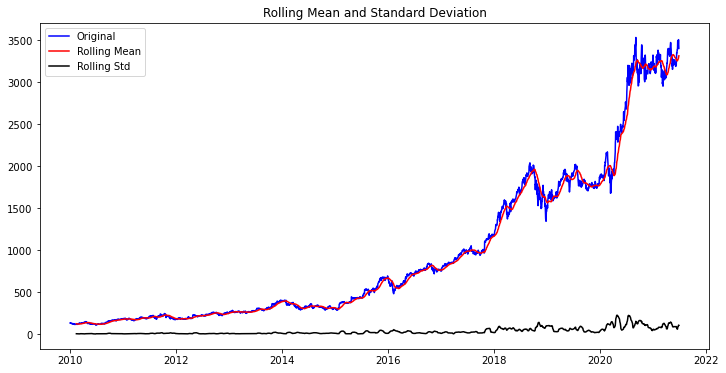

Results of dickey fuller test
Test Statistics                   2.365489
p-value                           0.998993
No. of lags used                 27.000000
Number of observations used    2862.000000
critical value (1%)              -3.432637
critical value (5%)              -2.862550
critical value (10%)             -2.567308
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.figure(figsize=(12,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(amzn_dataset.Close)

In [ ]:
We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. 
Also, the test statistics is greater than the critical values. so the data is non-stationary.

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

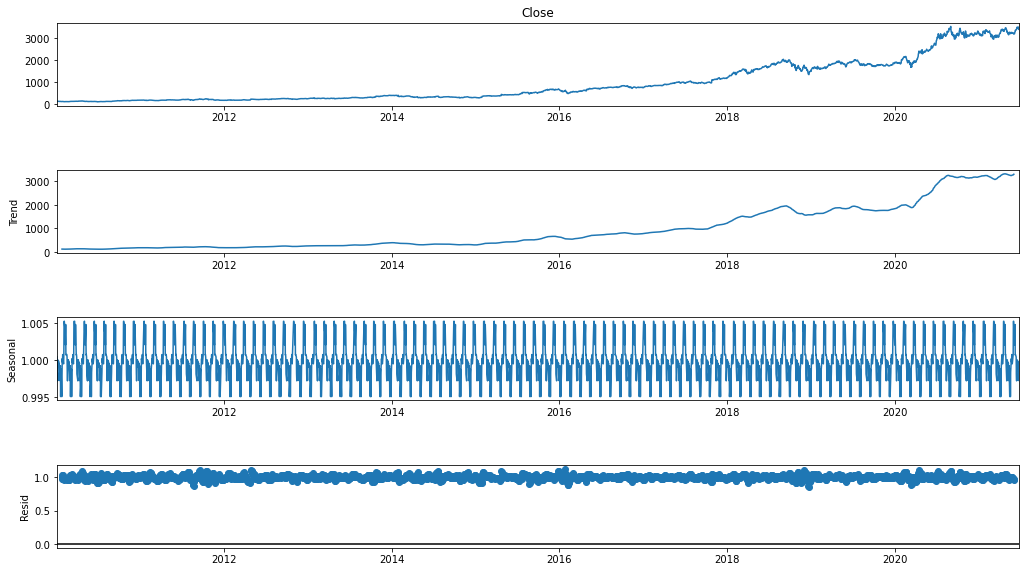

In [11]:
result = seasonal_decompose(amzn_dataset.Close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


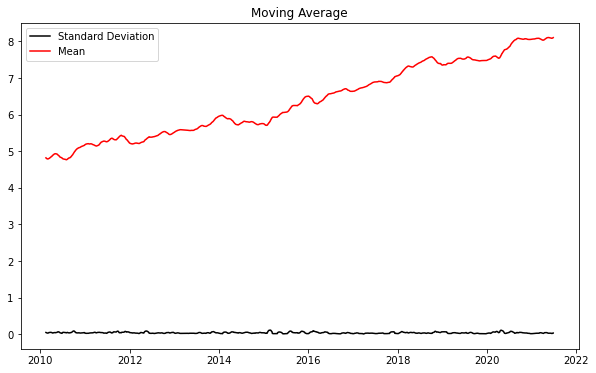

In [6]:
rcParams['figure.figsize'] = 10, 6
df_log = np.log(amzn_dataset.Close)
moving_avg = df_log.rolling(30).mean()
std_dev = df_log.rolling(30).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

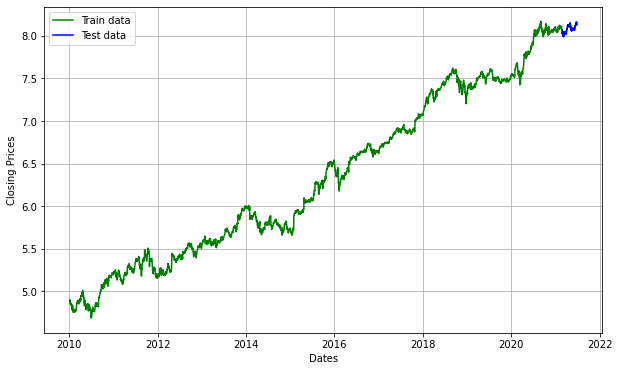

In [7]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.97)], df_log[int(len(df_log)*0.97):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [17]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13983.360, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13983.491, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13983.550, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13976.142, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13985.595, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13979.998, Time=1.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13981.586, Time=0.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13982.104, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-13981.969, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13981.018, Time=1.83 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13975.346, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 6.939 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

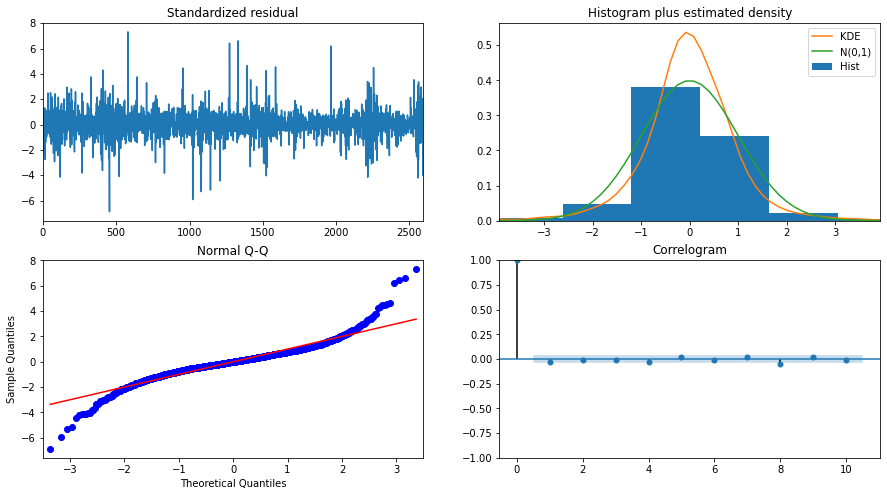

In [64]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

<b> Build ARIMA Model </b>

In [18]:
model = ARIMA(train_data, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2799
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6996.988
Method:                       css-mle   S.D. of innovations              0.020
Date:                Wed, 01 Sep 2021   AIC                         -13985.975
Time:                        23:23:49   BIC                         -13962.227
Sample:                             1   HQIC                        -13977.403
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.000      3.801      0.000       0.001       0.002
ar.L1.D.Close     0.8837      0.089      9.880      0.000       0.708       1.059
ma.L1.D.Close    -0.9065      0.081    -

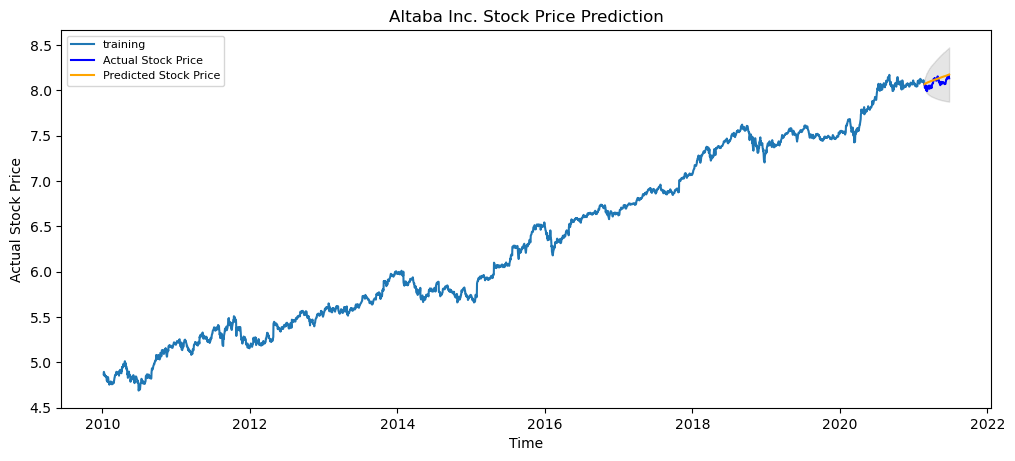

In [20]:
# Forecast
fc, se, conf = fitted.forecast(87, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

<b> Evaluate ARIMA Model </b> 

In [25]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE_error = MAPE(test_data, fc)
print('Testing Mean Absolute Error is {}'.format(MAPE_error))

Testing Mean Absolute Error is 0.5402499931739349


In [ ]:
#Around 5.4 MAPE (Mean Absolute Percentage Error) implies the model is about 95.4% accuracte in predicting the test set observations. 